## 1. Simulation
Simulate the process of magnetization based on 2D Ising model, assume no external magnetic field. Use Metroplolis Algorithm.

In [95]:
from jpype import *
import sys
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
sys.path.append("/Users/qche8799/OneDrive/infodynamics-dist-1.6.1/demos/python")
import readIntsFile
import plotly.graph_objs as go
from plotly.offline import plot

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "/Users/qche8799/OneDrive/infodynamics-dist-1.6.1/infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

### Description of process
Consider a set $\Lambda$ of lattice sites in 2D, each site $i$ has a spin $\sigma_i\in\{-1,+1\}$. For each adjacent site $i,j$ there is an interaction $J_{ij}$ between them. Assume interaction strength is the same everywhere in the lattice, and hence $J_{ij}=J$. Consider only energy in the links between the nearest 4 neighbors. Without external magnetic field, the energy of a specific configuration $\underline{\sigma}=\{\sigma_1, ..., \sigma_N\}$ is therefore:

$E(\underline{\sigma}) = -\sum_{<i,j>}{J\sigma_i\sigma_j} = -\sum_{<i,j>}{J\mu_{i,j}}$

Where $<i,j>$ denotes sum over all the adjacent neighbors $i,j$, and $\mu_{i,j}$ represents the interaction between two neighboring sites, with +1 represents alignment and -1 represents misalignment. Note that this formualtion of energy favours alignment between sites (i.e. lower energy when sites are aligned).

The Boltzmann distribution describes the probability of configuration $\underline{\sigma}$ as:

$p_{\beta}(\underline{\sigma}) = \frac{e^{-\beta E(\underline{\sigma})}}{Z_{\beta}}$

Where $\beta = 1/(k_B T)$ is the inverse of temperature.

#### The metropolis algorithm:
This algorithm evolves the system to equilibrium:
1. start with a square NxN lattice
2. randomly choose a site i, now we need to decide wether or not the flip the spin of this site. Let initial energy be E_i and the energy of the flipped state be E_f.
3. if E_i>E_f, flipping results in a lower energy state, hence flip spin(i)
4. if E_i<E_f, the site still has some probability $e^{-\beta(E_f-E_i)}$ of flipping the spin
5. repeat the process from 1

In [2]:
def initialise(N, bias=0.5, seed=0):
    ''' randomly initialise an N*N matrix with {-1,+1}. Bias is the probability of up spins.'''
    np.random.seed(seed)
    config = np.random.choice([1, -1], size=(N, N), p=[bias, 1-bias])
    return config

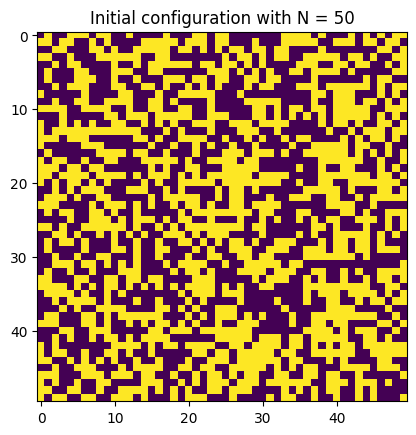

In [3]:
# visualise initial lattice, yellow = +1
N = 50
lattice = initialise(N, bias=0.5, seed=10)
plt.imshow(lattice);
plt.title(f'Initial configuration with N = {N}');

In [4]:
def get_mu(lattice):
    # applies the nearest neighbours summation, assumes J=1
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    # total energy should be divided by 2 as each of the neighboring <i,j> pair contributed once to the energy
    return arr.sum()/2

In [5]:
get_mu(lattice)

-8.0

In [6]:
def get_magnetisation(lattice):
    # average spin
    return lattice.sum()/lattice.size

In [7]:
get_magnetisation(lattice)

0.0128

In [34]:
@numba.njit("UniTuple(f8[:], 6)(i8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(lattice, time, J, mu):
    ''' Perform flip on one random site each time, assume beta=1 or T = 1/kB for Boltzmann distribution '''
    beta = 1 # beta = 1/(kB*T), assume temperature is constant 1/kB
    N = lattice.shape[0]

    # save energies and magnetisation for checking
    mus = np.zeros(time)
    magnetisations = np.zeros(time)
    
    # save values for perception-action loop
    spin = np.zeros(time)
    S = np.zeros(time) # sensory values at time t, sum of sigma_i*sigma_j for four neighbours
    A = np.zeros(time) # actions at time t
    SNext = np.zeros(time) # sensory values at time t+1, sum of sigma_i*sigma_j for four neighbours

    for t in range(time):
        mus[t] = mu # net interactions mu = E/J = -sum<i,j>{sigma_i*sigma_j} across the whole lattice
        magnetisations[t] = lattice.sum()/lattice.size
            
        # at each time step, randomly choose a site, compute energy before and after flipping
        x,y = np.random.randint(N), np.random.randint(N)
        spin_i = lattice[x][y] # initial spin
        spin_f = -1*spin_i # spin after flipping
        
        # compute change in Energy/J, E/J=sum<i,j>{-si*sj}
        mu_i = 0
        mu_f = 0
        if x>0:
            mu_i -= spin_i*lattice[x-1][y]
            mu_f -= spin_f*lattice[x-1][y]
        if x<N-1:
            mu_i -= spin_i*lattice[x+1][y]
            mu_f -= spin_f*lattice[x+1][y]
        if y>0:
            mu_i -= spin_i*lattice[x][y-1]
            mu_f -= spin_f*lattice[x][y-1]
        if y<N-1:
            mu_i -= spin_i*lattice[x][y+1]
            mu_f -= spin_f*lattice[x][y+1]
        dmu = mu_f - mu_i # change in energy after flipping

        S[t] = mu_i # "energy" sensor (senses E/J), when particles align S is negative
        if dmu<0 or np.random.rand()<np.exp(-beta*J*dmu):
            A[t] = -1 # flip the spin
            lattice[x][y] = spin_f
            spin[t] = spin_f
            SNext[t] = mu_f # energy for the chosen site
            mu += dmu # energy in aggregate
        else:
            spin[t] = spin_i
            A[t] = 1 # don't flip the spin
            SNext[t] = mu_i # energy for the chosen site 
    
    return spin, S, A, SNext, mus, magnetisations

/Users/qche8799/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/infodynamics-dist-1.6.1/demos/python/jpype_env/lib/python3.11/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [37]:
def simulation(N, time, J, bias=0.5, seed=0, plot=True):
    # initialise lattice
    lattice = initialise(N, bias, seed)
    
    if plot:
        # run metropolis algorithm and plot the process
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        stepsToPlot = 10**int(np.log10(time)-1) # make a plot for every X number of steps

        # values to keep
        spins = np.array([], dtype=np.int8)
        senses = np.array([],dtype=np.int8)
        actions = np.array([],dtype=np.int8)
        sensesNext = np.array([],dtype=np.int8)
        mus = np.array([])
        magnetisations = np.array([])
    
        for i, ax in enumerate(axes.flatten()):
            if i < 7:
                ax.imshow(lattice)
                ax.set_title(f'Time = {i*stepsToPlot}')
                sp, s, a, sNext, mu, m = metropolis(lattice, stepsToPlot, J, get_mu(lattice))
            else:
                # for the last one run the rest of the steps and plot
                sp, s, a, sNext, mu, m = metropolis(lattice, time - i*stepsToPlot, J, get_mu(lattice))
                ax.imshow(lattice)
                ax.set_title(f'Time = {time}')
            spins = np.append(spins, sp)
            senses = np.append(senses, s)
            actions = np.append(actions, a)
            sensesNext = np.append(sensesNext, sNext)
            mus = np.append(mus, mu)
            magnetisations = np.append(magnetisations, m)
    else:
        # just run simulation
        spins, senses, actions, sensesNext, mus, magnetisations = metropolis(lattice, time, J, get_mu(lattice))
    
    return np.int8(spins), np.int8(senses), np.int8(actions), np.int8(sensesNext), mus, magnetisations
        

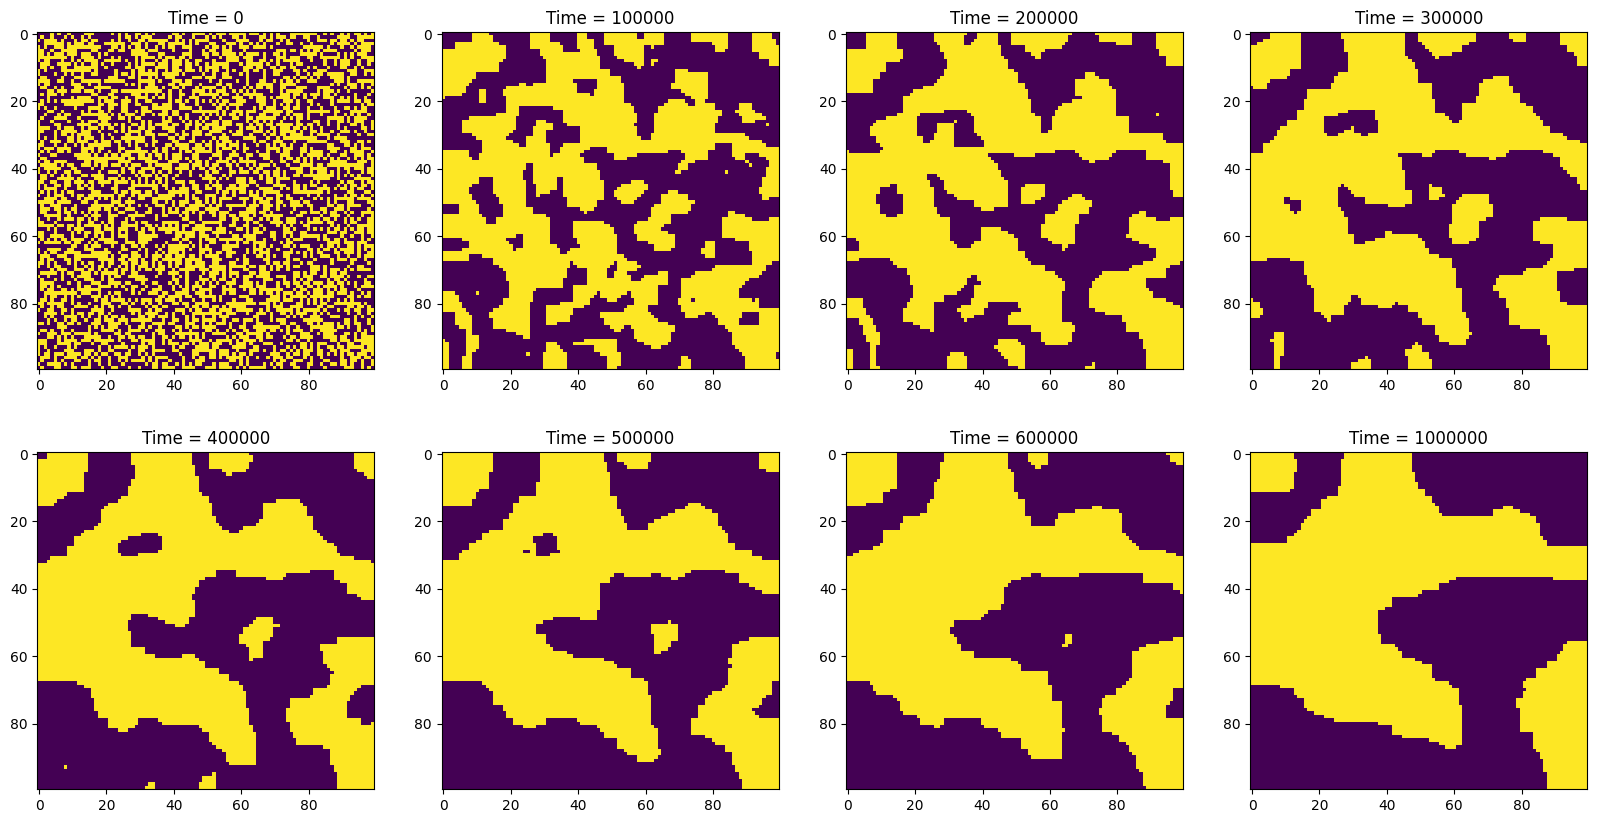

In [10]:
N = 100
time = 1000000
J = 2
spins, senses, actions, sensesNext, mus, magnetisations = simulation(N, time, J, bias=0.5, seed=0)

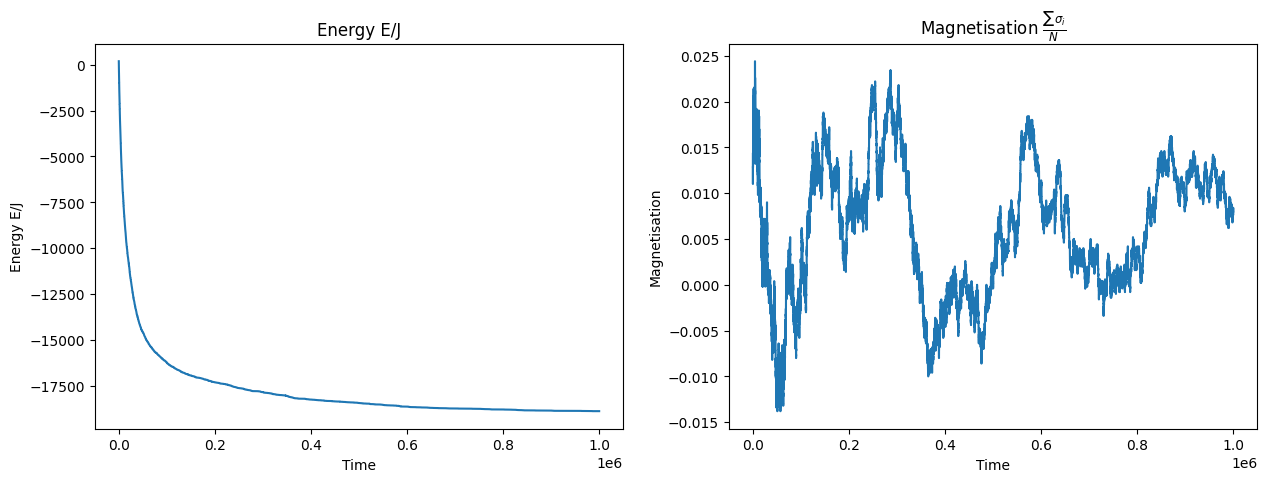

In [13]:
# plot energy and magnetisation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(range(time), mus);
ax.set_title('Energy E/J');
ax.set_xlabel('Time');
ax.set_ylabel('Energy E/J');
ax = axes[1]
ax.plot(range(time), magnetisations);
ax.set_title(r'Magnetisation $\frac{\sum{\sigma_i}}{N}$');
ax.set_xlabel('Time');
ax.set_ylabel('Magnetisation');

## 2. Predictive Information
Compute predictive information and plot values w.r.t. BJ

In [14]:
def mutual_information(source, destination, sourceBase, destinationBase):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
    calc = calcClass(sourceBase, destinationBase, 0) # use timeDiff = 0
    # 2. No other properties to set for discrete calculators.
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()

    # 4. Supply the sample data:
    # check input dimension:
    if source.ndim >1:
        for k in range(source.shape[1]):
            src = JArray(JInt, 1)(source[:,k].tolist())
            dest = JArray(JInt, 1)(destination[:,k].tolist())
            calc.addObservations(src, dest)
    else:
        src = JArray(JInt, 1)(source.tolist())
        dest = JArray(JInt, 1)(destination.tolist())
        calc.addObservations(src, dest)  
            
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    return result

def entropy(source, sourceBase):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.discrete").EntropyCalculatorDiscrete
    calc = calcClass(sourceBase)
    # 2. No other properties to set for discrete calculators.
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()

    # 4. Supply the sample data:
    # check input dimension:
    if source.ndim >1:
        for k in range(source.shape[1]):
            # 0. Load/prepare the data:
            src = JArray(JInt, 1)(source[:,k].tolist())
            calc.addObservations(src)
    else:
        src = JArray(JInt, 1)(source.tolist())
        calc.addObservations(src)  
        
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations() #unit = bits
    return result

def conditional_entropy(source, condition, sourceBase, conditionBase):
    entropySource = entropy(source, sourceBase) #H(S)
    miSourceCondition = mutual_information(source, condition, sourceBase, conditionBase) #I(S;C)
    condEntropy = entropySource - miSourceCondition # H(S|C) = H(S) - I(S;C)
    return condEntropy

Check if PI makes sense:
where J is very low (assume beta=1), all the sites starts to jiggle. As J->0, p(flip)->1, and we shall observe $(S_t,S_{t+1}) = (s,-s)$ almost all of the time. $I(S_t,S_{t+1})$ is therefore maximized, and approximately $H(S_t)$ = log2(#values of s) = log2(5) as the majority of sites are internal (i.e. with 4 neigbours), so $\sum_{<i,j>}{\sigma_i\sigma_j}\in\{-4,-2,0,2,4\}$. The conditional entropy is zero in this case.

In [15]:
offset = 4 # convert range [-4,4] to [0,8] for mi computation
base = 2*offset+1
S = senses[-100000:] + offset # take only the last 100k observations
SNext = sensesNext[-100000:] + offset
pi = mutual_information(S, SNext, base, base)
etp = entropy(SNext, base)
condEtp = conditional_entropy(SNext, S, base, base)
print(f'J={J}: predictive information = {pi:.4f} bits, H(SNext) = {etp:.4f} bits, H(SNext|S) = {condEtp:.4f} bits')

J=2: predictive information = 0.6987 bits, H(SNext) = 0.6995 bits, H(SNext|S) = 0.0009 bits


In [16]:
%%time
# run for multiple J and compute pi for each J
Js = np.linspace(0.01,3,100)
N = 100
time = 1000000
pis = {}
etps = {}
offset = 4 # convert range [-4,4] to [0,8] for mi computation
base = 2*offset+1
numSample = 100000 # take 10k observations to compute pi

for j in Js:
    spins, senses, actions, sensesNext, mus, magnetisations = simulation(N, time, j, bias=0.5, seed=0, plot=False)
    S = senses[-numSample:] + offset # take the last 100k observations, disregard transient
    SNext = sensesNext[-numSample:] + offset
    pis[j] = mutual_information(S, SNext, base, base)
    etps[j] = entropy(SNext, base)

CPU times: user 7min 18s, sys: 2.23 s, total: 7min 21s
Wall time: 7min 21s


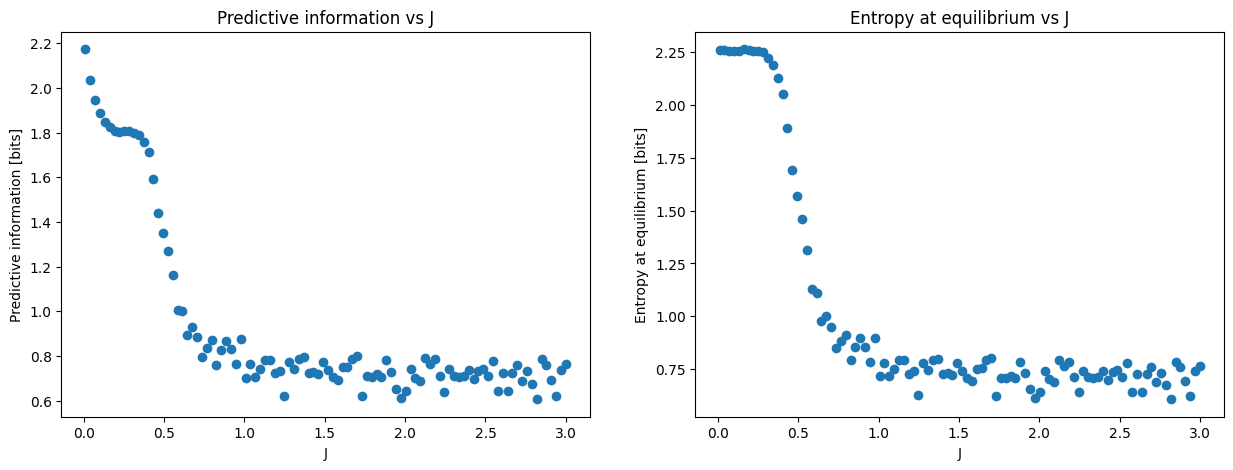

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.scatter(pis.keys(), pis.values())
ax.set_title('Predictive information vs J');
ax.set_xlabel('J');
ax.set_ylabel('Predictive information [bits]');
ax = axes[1]
ax.scatter(etps.keys(), etps.values())
ax.set_title('Entropy at equilibrium vs J');
ax.set_xlabel('J');
ax.set_ylabel('Entropy at equilibrium [bits]');

## 3. Empowerment
Compute average empowerment (channel capacity) and plot values w.r.t J

### Channel capacity
Considering an arbitrary site i in the lattice. $\sigma_i$ denotes its spin and $\mu_i=\sum_{<i,j>}{-\sigma_i\sigma_j}=\frac{E}{J}$ measures its energy (scaled by a factor J). Lower energy (i.e. negative $\mu$) or equivalently, alignment with neighbors, is preferred.

For this single site, let sensory state $S_t = \mu_i(t)$ and $A_t\in\{flip, no-flip\}$. The action channel of the site is characterised by the conditional probability p(s'|a,s), where s' is the value of the sensory state following an action, given that the site starts from S=s. If $S_t=s$, after flip/no-flip action, the only possible values for $S_{t+1}$ are {s, -s} (except that when s=0 then only one value is possible). Therefore we essentially have a channel looks like {flip, no-flip}$\rightarrow${-s, s}, and the mapping is deterministic. This is the embodiment of the site (agent).

With a binary channel like this, the channel capacity (maximum mutual information max$I(S_{t+1}, A_t)$) C(s)=1 bit, and it's achieved when the distribution between {flip, no-flip} is uniform (50/50 chance). This is true for all values of $s\in\{-4,-3,-2,-1,1,2,3,4\}$. Therefore all these states are equally empowered, if the site is free to designate its action distributions.

The channel capacity of s=0, C(0)=0, because no matter how the site acts (flip or not), it can only perceive s=0. 

Therefore, a more empowered state is where the lattice has net magnetisation $\neq0$, i.e. empoewrment is high when sites are aligned.

Let the subset of S states where channel capacity is nonzero be $\Gamma=\{-4,-3,-2,-1,1,2,3,4\}$. The average empowerment given control parameter J is: $\mathcal{E}(S;J) = \sum{p(s;J)\mathcal{E}(s)}=\sum_{s\in\Gamma}{p(s;J)\times1}$

### Mutual information
On the other hand, we can also compute the actual mutual information (instead of its potential maximum) under the constraint of the "controller" that regulates the action distribution of the site. For a given channel s, the action distribution p(a) is:

- When s < 0: p(flip) = $e^{2\beta Js}$, p(no flip) = 1- p(flip)
- When s >= 0: p(flip) = 1, p(np flip) = 0

Hence mutual information for a given channel s: $I(S_{t+1};A_t|S_t=s) = H(S_{t+1}|S_t=s) - H(S_{t+1}|A_t, S_t=s) = H(S_{t+1}|S_t=s) = -\sum{p*logp}$ (since flip$\rightarrow$-s and no-flip$\rightarrow$s is deterministic, the conditional entropy is zero)

- When s< 0: $I(S_{t+1};A_t|S_t=s) = p(flip)*logp(flip) + p(noflip)*logp(noflip))$ 
- When s>=0: 0

Let the subset of S states where mutual information is nonzero be $\Theta = \{-4,-3,-2,-1\}$. The average mutual information given control parameter J is:
$I(S_{t+1};A_t|J) = \sum{p(s;J)I(S_{t+1};A_t|J,s)} = -\sum_{s\in\Theta}{p(s;J)\{e^{2\beta Js}*log2(e^{2\beta Js}) + (1-e^{2\beta Js})*log2(1-e^{2\beta Js})\}}$ bits

Compared with empowerment, average mutual information gives smaller weight to full alignments $H(S_{t+1}|S=-4) << 1$ when J is large (as we have a very skewed distribution of $S_{t+1}$). The larger is J, the further away is $p(a)$ from optimal $p^*(a)$ (which is 1/2, 1/2)

In [ ]:
%%time
# run for multiple J and compute average empowerment for each J
Js = np.linspace(0.01,3,100)
N = 100
time = 1000000
emps = {}
# mis0 = {}
# mis1 = {}
mis = {}
numSample = 100000 # take 10k observations to compute empowerment
offsetA = 1
offsetS = 4
baseA = 2
baseS = 9

for j in Js:
    spins, senses, actions, sensesNext, mus, magnetisations = simulation(N, time, j, bias=0.5, seed=0, plot=False)
    S = senses[-numSample:]
    A = actions[-numSample:]
    SNext = sensesNext[-numSample:] # take the last 100k observations, disregard transient
    # compute average empowerment (channel capacity)
    emps[j] = sum(SNext!=0)/numSample
    # compute average mutual information with three different ways
    # s0neg =S[S<0]
    # p0 = np.exp(2*j*s0neg) # assume beta = 1
    # mis0[j] = -(p0@np.log2(p0) + (1-p0)@np.log2(1-p0))/numSample # approx p(s) with empirical probability
    # s1neg = SNext[SNext<0]
    # p1 = np.exp(2*j*s1neg)
    # mis1[j] = -(p1@np.log2(p1) + (1-p1)@np.log2(1-p1))/numSample
    mis[j] =  mutual_information((A + offsetA)//2, SNext + offsetS, baseA, baseS)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.scatter(emps.keys(), emps.values())
ax.set_title('Average empowerment vs J');
ax.set_xlabel('J');
ax.set_ylabel('Average empowerment [bits]');
ax = axes[1]
ax.scatter(mis.keys(), mis.values())
# ax.plot(mis0.keys(), mis0.values())
# ax.plot(mis1.keys(), mis1.values())
ax.set_title('Average mutual information at equilibrium vs J');
ax.set_xlabel('J');
ax.set_ylabel('Average mutual information [bits]');

In [ ]:
pos = np.argmax(list(mis.values()))
jmax = list(mis.keys())[pos]

In [ ]:
N = 100
time = 1000000
spins, senses, actions, sensesNext, mus, magnetisations = simulation(N, time, jmax, bias=0.5, seed=0)

# plot energy and magnetisation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(range(time), mus);
ax.set_title('Energy E/J');
ax.set_xlabel('Time');
ax.set_ylabel('Energy E/J');
ax = axes[1]
ax.plot(range(time), magnetisations);
ax.set_title(r'Magnetisation $\frac{\sum{\sigma_i}}{N}$');
ax.set_xlabel('Time');
ax.set_ylabel('Magnetisation');

## 4. Thermodynamic efficiency
$\eta$ describes the amount of work done by changing the control parameter that goes to change the structure of the system, it has a unit of bit/joule. It is defined as follow:
$\eta = \frac{\partial S/\partial X}{\partial W/\partial X} = \frac{\partial S/\partial J}{\int F(J)dJ}$
where S is entropy of the system, X is control parameter, W is work done by changing the control parameter. The denominator is equivalent to integrating fisher information w.r.t the control parameter.

To compute $\eta$, we need the following quantities:

- entropy of system at configuration $S(\underline{\sigma}; J)$, where $\underline{\sigma} = \{\sigma_1, ..., \sigma_{N*N}\}$ $\rightarrow$ computed in section 2
- derivative of entropy w.r.t. J
- Fisher information of control parameter J $F(J) = 4*\sum_{x}{(\sqrt{p(x;J+dJ)} - \sqrt{p(x;J-dJ)})^2}$
- integral of fisher information w.r.t. J

In [18]:
@numba.njit("f8[:](f8[:], f8[:])", nopython=True, nogil=True)
def get_derivatives(xVals, fxVals):
    ''' Assume x are equally spaced, compute df/dx.
    x: numpy array, sorted
    fx: numpy array
    Return derv: numpy array
    '''
    dx = xVals[1] - xVals[0]
    derv = np.zeros(len(xVals), dtype=np.float64)
    for i, x in enumerate(xVals):
        if i == 0: 
            derv[i] = (fxVals[i+1] - fxVals[i])/dx #forward difference for the first point
        elif i == len(xVals) - 1:
            derv[i] = (fxVals[i] - fxVals[i-1])/dx #backward difference for the last point
        else:
            derv[i] = (fxVals[i+1] - fxVals[i-1])/(2*dx) #central difference for all other points
    return derv

/Users/qche8799/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/infodynamics-dist-1.6.1/demos/python/jpype_env/lib/python3.11/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


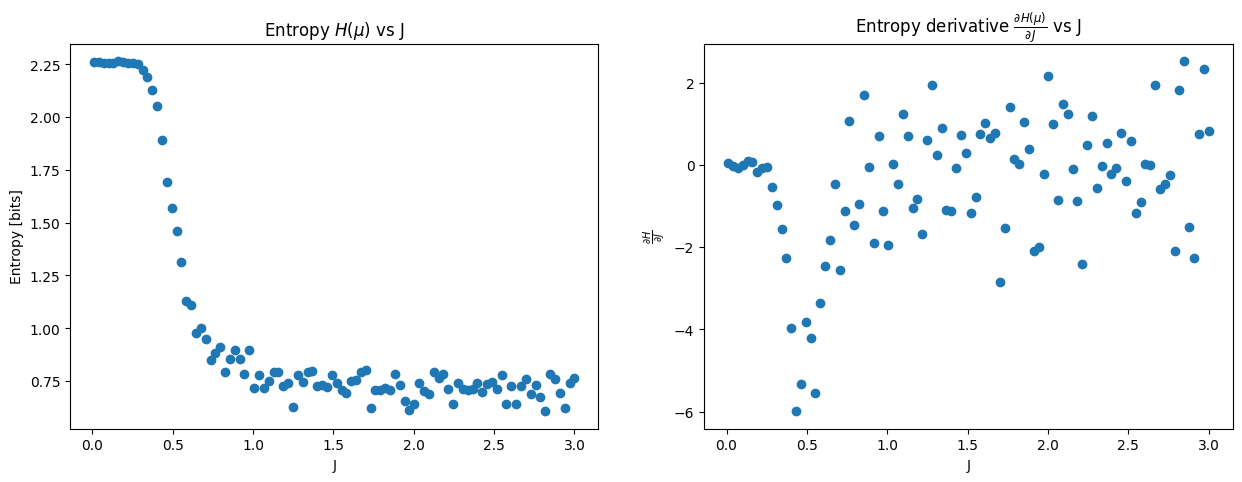

In [81]:
etpsDerv = get_derivatives(np.array(list(etps.keys())), np.array(list(etps.values())))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.scatter(etps.keys(), etps.values())
ax.set_title(r'Entropy $H(\mu)$ vs J');
ax.set_xlabel('J');
ax.set_ylabel('Entropy [bits]');
ax = axes[1]
ax.scatter(etps.keys(), etpsDerv)
ax.set_title(r'Entropy derivative $\frac{\partial H(\mu)}{\partial J}$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$\frac{\partial H}{\partial J}$');

In [32]:
def get_pdf(samples):
    sigma, counts = np.unique(samples, return_counts=True)
    p = {}
    for sig, cnt in zip(sigma, counts):
        p[sig] = cnt/samples.size
    return p

In [31]:
p = get_pdf(lattice)
print(f'Average spin: {p[-1]*-1+p[1]:.4f}')
print(f'Check with magnetisation: {get_magnetisation(lattice)}')

Average spin: 0.0128
Check with magnetisation: 0.0128


In [74]:
%%time
# run for multiple J and compute pi for each J
Js = np.linspace(0.01,3,100)
N = 100
time = 1000000
etpSigma = {}
pdf = {}
offsetSigma = 1 # convert range [-4,4] to [0,8] for mi computation
baseSigma = 2*offsetSigma+1
numSample = 100000 # take 10k observations to compute pi

for j in Js:
    spins, senses, actions, sensesNext, mus, magnetisations = simulation(N, time, j, bias=0.75, seed=0, plot=False)
    pdf[j] = get_pdf(spins[-numSample:])
    etpSigma[j] = entropy((spins[-numSample:]+offsetSigma)//2, baseSigma)

CPU times: user 6min 21s, sys: 2.1 s, total: 6min 23s
Wall time: 6min 23s


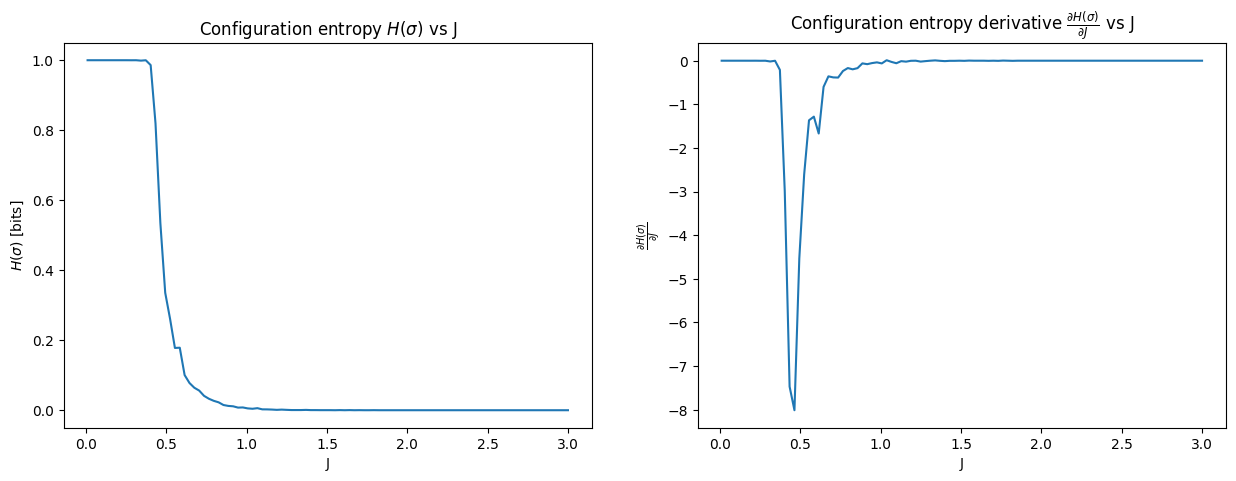

In [86]:
etpSigmaDerv = get_derivatives(np.array(list(etpSigma.keys())), np.array(list(etpSigma.values())))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(etpSigma.keys(), etpSigma.values())
ax.set_title(r'Configuration entropy $H(\sigma)$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$H(\sigma)$ [bits]');
ax = axes[1]
ax.plot(etpSigma.keys(), etpSigmaDerv)
ax.set_title(r'Configuration entropy derivative $\frac{\partial H(\sigma)}{\partial J}$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$\frac{\partial H(\sigma)}{\partial J}$');

In [75]:
def get_fisher(pdf):
    # density function takes the form f(x;theta), input is a dictionary mapping theta to the corresponding f(x)
    # where theta is the parameter with respect to which we compute the fisher information
    # assume theta is uniformly spaced
    thetas = np.array(list(pdf.keys()))
    fisher = {}

    for i, theta in enumerate(pdf.keys()):
        if i == 0:
            # forward difference for the first theta
            thetaPlus = thetas[i+1]
            dTheta = thetaPlus - theta
            p = pdf[theta] #f(x;J)
            pPlus = pdf[thetaPlus] #f(x;J+dJ)
            allX = set(p.keys()).union(set(pPlus.keys())) # set of all possible sigmas {-1, 1}
            fi = 0
            for x in allX:
                fi = fi + 4 * ((pPlus.get(x,0)**0.5 - p.get(x,0)**0.5)/dTheta)**2 # fi = 4 * sum_x{(d_sqrt(p)/d_theta)^2}
        elif i == len(thetas) - 1:
            # backward difference for the last theta
            thetaMinus = thetas[i-1]
            dTheta = theta - thetaMinus
            p = pdf[theta]
            pMinus = pdf[thetaMinus] #f(x;J-dJ)
            allX = set(p.keys()).union(set(pMinus.keys())) 
            fi = 0
            for x in allX:
                fi = fi + 4 * ((p.get(x,0)**0.5 - pMinus.get(x,0)**0.5)/dTheta)**2
        else:
            # central difference for other thetas
            thetaMinus = thetas[i-1]
            thetaPlus = thetas[i+1]
            dTheta = thetaPlus - thetaMinus
            pMinus = pdf[thetaMinus]
            pPlus = pdf[thetaPlus] 
            allX = set(pPlus.keys()).union(set(pMinus.keys())) 
            fi = 0
            for x in allX:
                fi = fi + 4 * ((pPlus.get(x,0)**0.5 - pMinus.get(x,0)**0.5)/dTheta)**2 
        fisher[theta] = fi    
    return fisher

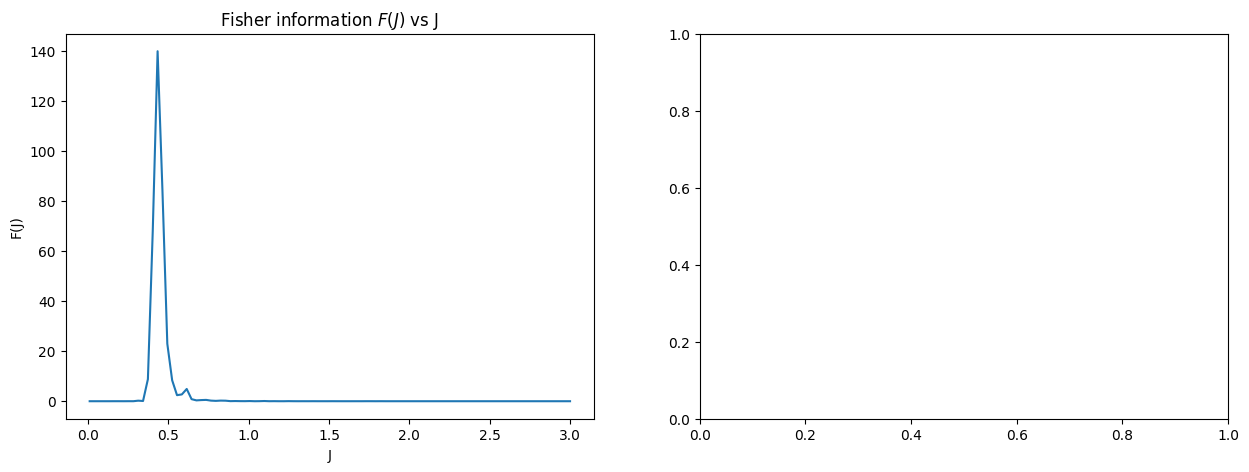

In [76]:
fisherInfo = get_fisher(pdf)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(fisherInfo.keys(), fisherInfo.values())
ax.set_title(r'Fisher information $F(J)$ vs J');
ax.set_xlabel('J');
ax.set_ylabel('F(J)');

In [77]:
def get_integral(xVals, fxVals, start, end):
    ''' Assume x equally spaced. Find sum_x(fx*dx) within range of integration'''
    dx = xVals[1] - xVals[0]
    integral = 0
    if start < end:
        integral = dx * fxVals[(xVals>=start) & (xVals<=end)].sum()
    elif start > end:
        integral = -dx * fxVals[(xVals<=start) & (xVals>=end)].sum()
    else:
        integral = np.nan
    return integral

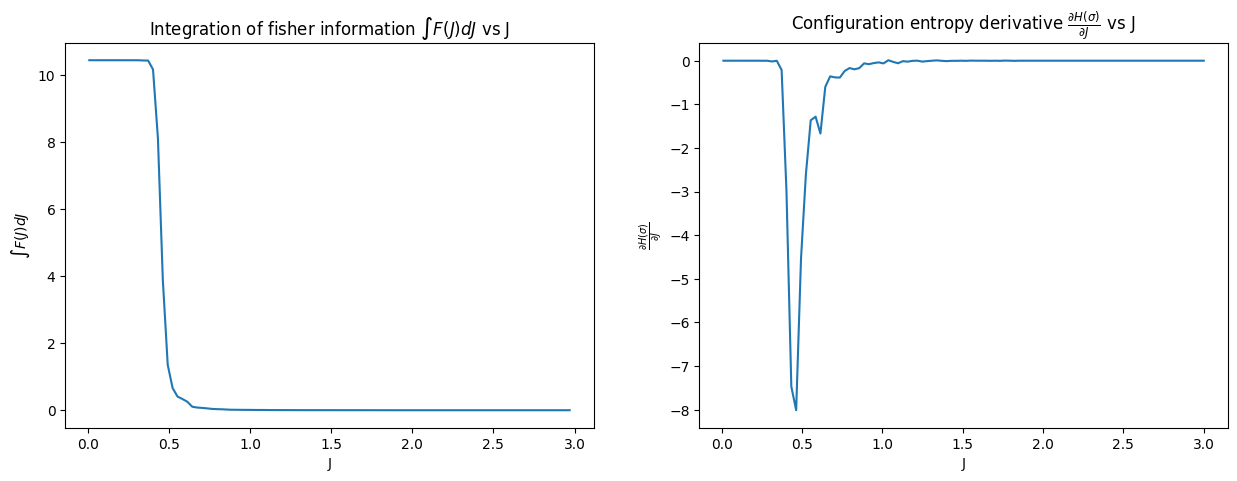

In [105]:
jVals = np.array(list(fisherInfo.keys()))
fiVals = np.array(list(fisherInfo.values()))
fiIntegrate = {}
for j in jVals:
    fiIntegrate[j] = get_integral(jVals, fiVals, j, jVals.max())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(fiIntegrate.keys(), fiIntegrate.values())
ax.set_title(r'Integration of fisher information $\int{F(J)}dJ$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$\int{F(J)}dJ$');
ax = axes[1]
ax.plot(etpSigma.keys(), etpSigmaDerv)
ax.set_title(r'Configuration entropy derivative $\frac{\partial H(\sigma)}{\partial J}$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$\frac{\partial H(\sigma)}{\partial J}$');

In [102]:
# make interactive plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(fiIntegrate.keys()), y=list(fiIntegrate.values()), name='integrate fi', mode='lines'))
fig.update_layout(title=r'Integration of fisher information $\int{F(J)}dJ$ vs J',
                  xaxis_title='J',
                  yaxis_title=r'$\int{F(J)}dJ$',
                  # autosize=False,  
                  # width=7*96,      
                  # height=5*96       
                  )
plot(fig, filename='integralfi.html', auto_open=True) 

'integralfi.html'

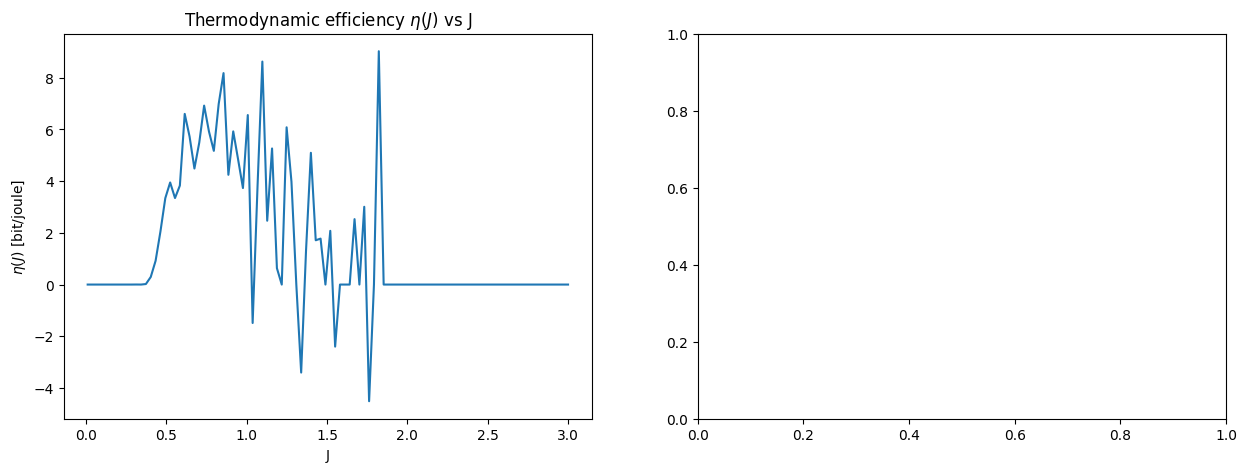

In [125]:
# thermodynamic efficiency
epsilon = 1e-6
eta = {}
for i, j in enumerate(fisherInfo.keys()):
    if fiIntegrate[j] != np.nan and abs(etpSigmaDerv[i]) > epsilon:
        eta[j] = - etpSigmaDerv[i]/fiIntegrate[j]
    else:
        eta[j] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
ax.plot(eta.keys(), eta.values())
ax.set_title(r'Thermodynamic efficiency $\eta(J)$ vs J');
ax.set_xlabel('J');
ax.set_ylabel(r'$\eta(J)$ [bit/joule]');